<a href="https://colab.research.google.com/github/ayumitakayuki/artificial_intelligence/blob/main/K3_ML_Tugas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# 1) PERSIAPAN LINGKUNGAN & IMPORT LIBRARY
# ------------------------------------------------------------
# - numpy, pandas  : manipulasi data dan array numerik
# - matplotlib     : visualisasi (scatter plot & garis regresi)
# - sklearn        : training & evaluasi model regresi linier
# - google.colab   : mengunggah file dari komputer ke Colab
# - joblib         : menyimpan model agar bisa dipakai ulang
# ============================================================

import io, sys, math, joblib  # io untuk membaca bytes upload; joblib untuk menyimpan model
import numpy as np            # operasi numerik (array, linspace)
import pandas as pd           # data frame dan analisis data tabular
import matplotlib.pyplot as plt  # visualisasi

from google.colab import files  # utilitas upload file di Colab

# Modul-modul dari scikit-learn:
from sklearn.model_selection import train_test_split  # membagi data train/test
from sklearn.linear_model import LinearRegression     # algoritma Regresi Linier Sederhana
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # metrik evaluasi

# Opsi tampilan supaya angka rapi dan grafik enak dilihat
plt.rcParams["figure.figsize"] = (7, 5)  # ukuran figur default (inci)
plt.rcParams["axes.grid"] = True         # tampilkan grid di grafik
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")  # format angka dengan 4 desimal

print("Lingkungan siap! Versi:")
print("Python :", sys.version.split()[0])


Lingkungan siap! Versi:
Python : 3.12.11


In [2]:
# ============================================================
# 2) UNGGAH & BACA DATASET CSV
# ------------------------------------------------------------
# - Di Colab, jalankan cell ini lalu pilih file CSV di komputer.
# - Pastikan dataset memiliki 2 kolom inti:
#     * YearsExperience  -> variabel fitur (X)
#     * Salary           -> variabel target (y)
# - Jika nama kolom berbeda, akan kita sesuaikan di sel berikutnya.
# ============================================================

print("Silakan pilih file CSV Anda (misal: Salary_dataset.csv)")
uploaded = files.upload()        # memunculkan dialog pemilihan file

# 'uploaded' adalah dict {nama_file: bytes}. Kita ambil nama file pertama.
csv_name = next(iter(uploaded))
print("File yang dibaca:", csv_name)

# Membaca CSV dari bytes upload menggunakan pandas
df = pd.read_csv(io.BytesIO(uploaded[csv_name]))

# Tampilkan ringkas info awal
print("Ukuran data (baris, kolom):", df.shape)
display(df.head())               # lihat 5 baris pertama
print("Nama kolom:", list(df.columns))


Silakan pilih file CSV Anda (misal: Salary_dataset.csv)


Saving Salary_dataset.csv to Salary_dataset.csv
File yang dibaca: Salary_dataset.csv
Ukuran data (baris, kolom): (30, 3)


,Unnamed: 0,YearsExperience,Salary
0,0,1.2000,"39,344.0000"
1,1,1.4000,"46,206.0000"
2,2,1.6000,"37,732.0000"
3,3,2.1000,"43,526.0000"
4,4,2.3000,"39,892.0000"


Nama kolom: ['Unnamed: 0', 'YearsExperience', 'Salary']


In [3]:
# ============================================================
# 3) PEMBERSIHAN DASAR & EDA RINGKAS
# ------------------------------------------------------------
# Tujuan:
# - Mengecek apakah ada nilai hilang (NA/NaN). Untuk demo ini,
#   kita drop baris yang memiliki NA agar tidak mengganggu model.
# - Menampilkan statistik deskriptif (mean, std, min, max, dll.)
# ============================================================

# Cek jumlah nilai hilang per kolom
print("Jumlah missing value per kolom:")
print(df.isna().sum())

# Hapus baris yang mengandung NA (jika ada). Untuk produksi,
# kadang lebih baik imputasi, tapi di tugas ini cukup di-drop.
df = df.dropna().copy()

# Statistik deskriptif: membantu memahami rentang & skala data
print("\nRingkasan statistik:")
display(df.describe(include="all"))


Jumlah missing value per kolom:
Unnamed: 0         0
YearsExperience    0
Salary             0
dtype: int64

Ringkasan statistik:


,Unnamed: 0,YearsExperience,Salary
count,30.0000,30.0000,30.0000
mean,14.5000,5.4133,"76,004.0000"
std,8.8034,2.8379,"27,414.4298"
min,0.0000,1.2000,"37,732.0000"
25%,7.2500,3.3000,"56,721.7500"
50%,14.5000,4.8000,"65,238.0000"
75%,21.7500,7.8000,"100,545.7500"
max,29.0000,10.6000,"122,392.0000"


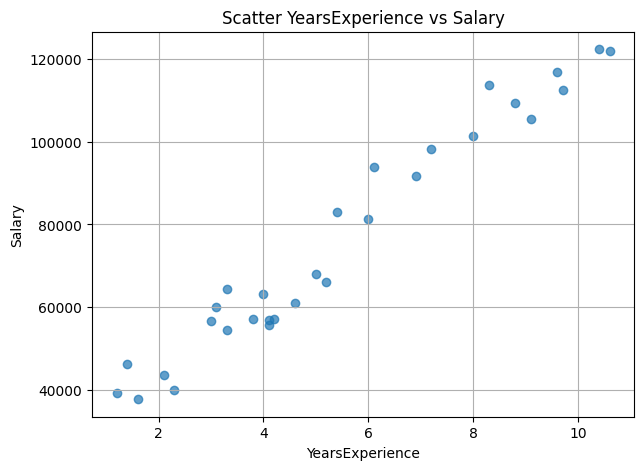

In [4]:
# ============================================================
# 4) PILIH FITUR & TARGET
# ------------------------------------------------------------
# - FEATURE_COL = nama kolom untuk variabel bebas (X)
# - TARGET_COL  = nama kolom untuk variabel terikat (y)
# - X harus berbentuk array 2D (n_sampel x 1) untuk sklearn.
# - y berbentuk array 1D (n_sampel,).
# - Kita juga tampilkan scatter plot untuk melihat pola linear.
# ============================================================

FEATURE_COL = "YearsExperience"  # ganti di sini jika nama kolom berbeda
TARGET_COL  = "Salary"           # ganti di sini jika nama kolom berbeda

# Pastikan kolom ada di dataset, jika tidak akan muncul error jelas
assert FEATURE_COL in df.columns and TARGET_COL in df.columns, \
    f"Kolom '{FEATURE_COL}' atau '{TARGET_COL}' tidak ditemukan. Cek nama kolom!"

# Bentuk X ke 2D: df[[kolom]] menghasilkan DataFrame (2D), bukan Series (1D)
X = df[[FEATURE_COL]].values  # shape: (n, 1)
y = df[TARGET_COL].values     # shape: (n,)

# Visual awal hubungan X vs y
plt.scatter(X, y, alpha=0.7)
plt.title(f"Scatter {FEATURE_COL} vs {TARGET_COL}")
plt.xlabel(FEATURE_COL)
plt.ylabel(TARGET_COL)
plt.show()


In [5]:
# ============================================================
# 5) TRAIN/TEST SPLIT, TRAINING MODEL, & EVALUASI
# ------------------------------------------------------------
# - train_test_split: membagi data menjadi set pelatihan dan uji.
#   test_size=0.2 artinya 20% data untuk pengujian.
#   random_state=42 agar hasil dapat direproduksi (opsional).
# - LinearRegression.fit() akan mencari koefisien terbaik (b0 & b1)
#   untuk meminimalkan error kuadrat (Ordinary Least Squares).
# - Kita hitung metrik:
#     * MAE  : rata-rata |y_true - y_pred|
#     * MSE  : rata-rata (y_true - y_pred)^2
#     * RMSE : akar dari MSE (satuan sama dengan target)
#     * R^2  : proporsi variansi y yang dijelaskan oleh model (0–1)
# ============================================================

# 5.1 Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5.2 Inisialisasi dan latih model regresi linier
model = LinearRegression()
model.fit(X_train, y_train)

# 5.3 Prediksi pada train & test set
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 5.4 Hitung metrik evaluasi pada test set
mae  = mean_absolute_error(y_test, y_pred_test)
mse  = mean_squared_error(y_test, y_pred_test)
rmse = math.sqrt(mse)
r2   = r2_score(y_test, y_pred_test)

# 5.5 Tampilkan hasil evaluasi & parameter model
print("=== Evaluasi pada Test Set ===")
print(f"MAE  (Mean Absolute Error) : {mae:,.4f}")
print(f"MSE  (Mean Squared Error)  : {mse:,.4f}")
print(f"RMSE (Root MSE)            : {rmse:,.4f}")
print(f"R^2  (Koef. Determinasi)   : {r2:,.4f}")

# Intercept (b0) = titik potong sumbu Y ketika X=0
# Slope (b1)     = kemiringan garis; perubahan rata-rata y untuk setiap +1 unit X
print("\n=== Parameter (Koefisien) Model ===")
print(f"Intercept (b0): {model.intercept_:,.6f}")
print(f"Slope     (b1): {model.coef_[0]:,.6f}")


=== Evaluasi pada Test Set ===
MAE  (Mean Absolute Error) : 6,286.4538
MSE  (Mean Squared Error)  : 49,830,096.8559
RMSE (Root MSE)            : 7,059.0436
R^2  (Koef. Determinasi)   : 0.9024

=== Parameter (Koefisien) Model ===
Intercept (b0): 24,380.201479
Slope     (b1): 9,423.815323


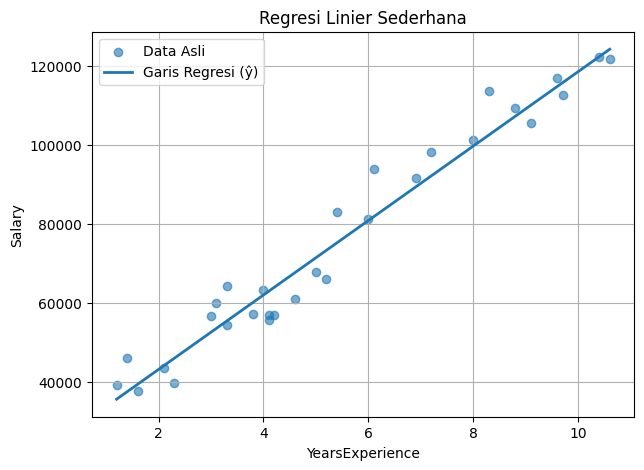

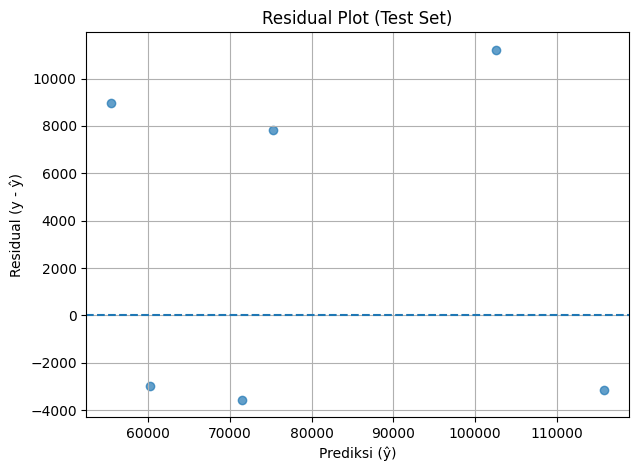

In [6]:
# ============================================================
# 6) VISUALISASI GARIS REGRESI & RESIDUAL PLOT
# ------------------------------------------------------------
# - Garis regresi: bantu melihat seberapa baik garis memotong data.
# - Residual plot: memeriksa pola error (harus acak di sekitar 0).
#   Jika ada pola lengkung/kipas, mungkin hubungan tidak linear
#   atau varians residual tidak homogen (heteroskedastisitas).
# ============================================================

# 6.1 Garis regresi di seluruh rentang X
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)  # 200 titik dari min sampai max
y_line = model.predict(x_line)  # prediksi y untuk setiap titik pada x_line

plt.scatter(X, y, alpha=0.6, label="Data Asli")
plt.plot(x_line, y_line, linewidth=2, label="Garis Regresi (ŷ)")
plt.title("Regresi Linier Sederhana")
plt.xlabel(FEATURE_COL)
plt.ylabel(TARGET_COL)
plt.legend()
plt.show()

# 6.2 Residual plot pada test set
residuals = y_test - y_pred_test  # selisih aktual - prediksi
plt.scatter(y_pred_test, residuals, alpha=0.7)
plt.axhline(0, linestyle="--")   # garis nol sebagai referensi
plt.title("Residual Plot (Test Set)")
plt.xlabel("Prediksi (ŷ)")
plt.ylabel("Residual (y - ŷ)")
plt.show()


In [7]:
# ============================================================
# 7) FUNGSI PREDIKSI CEPAT
# ------------------------------------------------------------
# - Fungsi berikut memudahkan Anda meminta prediksi untuk
#   nilai YearsExperience tertentu tanpa mengulang kode.
# - Mengembalikan satu nilai float (prediksi gaji).
# ============================================================

def predict_salary(years_experience: float) -> float:
    """
    Mengembalikan prediksi Salary (float) untuk input YearsExperience.
    Param:
        years_experience (float): banyaknya tahun pengalaman kerja.
    Return:
        float: nilai prediksi gaji sesuai model terlatih.
    """
    # Sklearn mengharapkan input 2D: bentuk (n_sampel, n_fitur)
    arr = np.array([[years_experience]], dtype=float)
    return float(model.predict(arr)[0])

# CONTOH PEMAKAIAN:
for val in [1, 3, 5, 10]:
    print(f"Prediksi Salary untuk {val} tahun pengalaman: {predict_salary(val):,.2f}")


Prediksi Salary untuk 1 tahun pengalaman: 33,804.02
Prediksi Salary untuk 3 tahun pengalaman: 52,651.65
Prediksi Salary untuk 5 tahun pengalaman: 71,499.28
Prediksi Salary untuk 10 tahun pengalaman: 118,618.35


,YearsExperience,PredictedSalary
0,1.000000,"33,804.02"
1,3.000000,"52,651.65"
2,5.000000,"71,499.28"
3,10.000000,"118,618.35"


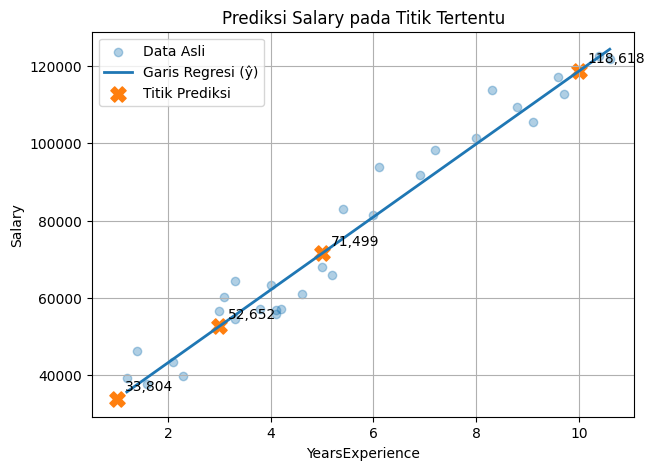

In [12]:
# ============================================================
# 7) VISUALISASI TITIK PREDIKSI
# ------------------------------------------------------------
# Visualisasi titik prediksi di atas garis regresi (butuh: model, X, y, FEATURE_COL, TARGET_COL)
# ============================================================

# Titik yang divisualkan
years = np.array([1, 3, 5, 10], dtype=float).reshape(-1, 1)

# Prediksi untuk titik-titik tersebut
preds = model.predict(years).reshape(-1)

# Tabel ringkas
pred_table = pd.DataFrame({
    "YearsExperience": years.reshape(-1),
    "PredictedSalary": preds
})
display(pred_table.style.format({"PredictedSalary": "{:,.2f}"}))

# Garis regresi untuk plot
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_line = model.predict(x_line)

# Plot data, garis regresi, dan titik prediksi
plt.scatter(X, y, alpha=0.35, label="Data Asli")
plt.plot(x_line, y_line, linewidth=2, label="Garis Regresi (ŷ)")
plt.scatter(years, preds, s=120, marker='X', label="Titik Prediksi")

# Label nilai di tiap titik
for x_val, y_hat in zip(years.reshape(-1), preds):
    plt.annotate(f"{y_hat:,.0f}", (x_val, y_hat), textcoords="offset points", xytext=(6,6))

plt.title("Prediksi Salary pada Titik Tertentu")
plt.xlabel(FEATURE_COL)
plt.ylabel(TARGET_COL)
plt.legend()
plt.show()
